# Lorenz system

This notebook will produce example data for the lorenz system and then identify the underlying ordinary differential equations.

## Time simulation

The `tsme` package provides a number of pre-implemented dynamical systems, so we simply import the class `Lorenz`. (See this [page](https://nonlinear-physics.zivgitlabpages.uni-muenster.de/ag-kamps/tsme/source/tsme.premade_models.html) for more models.)

In [2]:
%%capture
%cd ..
import numpy as np
from tsme.premade_models import Lorenz
import matplotlib.pyplot as plt

The lorenz system consists of the following coupled ordinary differential equations:
$$
\frac{\text{d}x}{\text{d}t} = \sigma \left(y - x \right) \\
\frac{\text{d}y}{\text{d}t} = x \left(\rho - z \right) - y \\
\frac{\text{d}z}{\text{d}t} = x\, y - \beta \, z
$$

So we set initial values for $x$, $y$ and $z$ as well as a time interval and discretization. The parameters are set to $\sigma = 10$, $\rho = 28$ and $\beta = 8/3$ during intitialization.

In [3]:
init = np.array([0.5, 0.5, 0.5])
time = np.linspace(0, 30, 2000)

system = Lorenz(ic=init, params=[10, 28, 8/3.])

Now we can generate an example trajectory by calling the function `simulate` and passing information about our time interval and the preferred solver method.

In [4]:
sol = system.simulate([time[0], time[-1]], method="RK45", t_eval=time)

IVP: 100%|##########| 30.0/30.0 [00:00<00:00, 324.87ut/s]


We take a look at the trajectory in phase space using matplotlib:

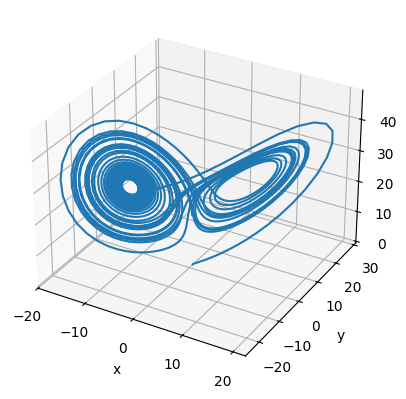

In [5]:
%matplotlib inline
ax = plt.figure().add_subplot(projection="3d")
ax.plot3D(sol[0], sol[1], sol[2])
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
plt.show()

## Infer differential equations

Now we import the model that will 'learn' the differential equations from `tsme`.

In [6]:
from tsme.model_estimation.model import Model

We need to pass the trajectory and the time stamps to our model. Then we can automatically generate a library of possible test functions for each right-hand side. Here we take all products of third order for the number of variables we supplied in our trajectory array.

In [7]:
estimated_model = Model(sol, time)
estimated_model.init_library(ode_order=3)
estimated_model.print_library()

|   Index | Term           |   Value 0 |   Value 1 |   Value 2 |
|---------|----------------|-----------|-----------|-----------|
|       0 | 1.0            |         0 |         0 |         0 |
|       1 | u[0]           |         0 |         0 |         0 |
|       2 | u[1]           |         0 |         0 |         0 |
|       3 | u[2]           |         0 |         0 |         0 |
|       4 | u[0]*u[0]      |         0 |         0 |         0 |
|       5 | u[0]*u[1]      |         0 |         0 |         0 |
|       6 | u[0]*u[2]      |         0 |         0 |         0 |
|       7 | u[1]*u[1]      |         0 |         0 |         0 |
|       8 | u[1]*u[2]      |         0 |         0 |         0 |
|       9 | u[2]*u[2]      |         0 |         0 |         0 |
|      10 | u[0]*u[0]*u[0] |         0 |         0 |         0 |
|      11 | u[0]*u[0]*u[1] |         0 |         0 |         0 |
|      12 | u[0]*u[0]*u[2] |         0 |         0 |         0 |
|      13 | u[0]*u[1]*u[1

Of course just after initialization the linear factors of all these library terms are yet to be determined. We tell our model to construct a simulator with the above library that can facilitate time simulations. (The library supports some basic manipulations at this point, but more on that in a future tutorial). Now we can call the optimization routine to find the best combination of our trial functions. (For more detail see [here](https://nonlinear-physics.zivgitlabpages.uni-muenster.de/ag-kamps/tsme/source/tsme.html#tsme.model_estimation.model.Model.optimize_sigma))

In [8]:
estimated_model.init_simulator()
estimated_model.optimize_sigma(lamb=0, thres=0.1, max_it=100, error="BIC")

Generating library functions (this may take some time)...
100%|██████████| 20/20 [00:00<00:00, 21.03trial/s, best loss: -563.8248260730334]
Optimal threshold(s) found: {'t0': 0.6318838657790797, 't1': 0.009073188506506291, 't2': 0.6970368357006939}
New Sigma set to: 

|   Index | Term      |   Value 0 |   Value 1 |   Value 2 |
|---------|-----------|-----------|-----------|-----------|
|       0 | 1.0       |   0       | -0.026982 |  0        |
|       1 | u[0]      |  -9.95414 | 27.3657   |  0        |
|       2 | u[1]      |   9.95443 | -0.876594 |  0        |
|       3 | u[2]      |   0       |  0        | -2.6483   |
|       5 | u[0]*u[1] |   0       |  0        |  0.992512 |
|       6 | u[0]*u[2] |   0       | -0.981003 |  0        |


As we can see the dynamics are correctly identified, albeit with some error. We can also check how the model performs when looking at the time simulation:

In [9]:
t = estimated_model.time
sol_est = estimated_model.simulator.simulate([t[0], t[-1]], method="RK45", t_eval=t)

IVP: 100%|##########| 30.0/30.0 [00:00<00:00, 197.49ut/s]              


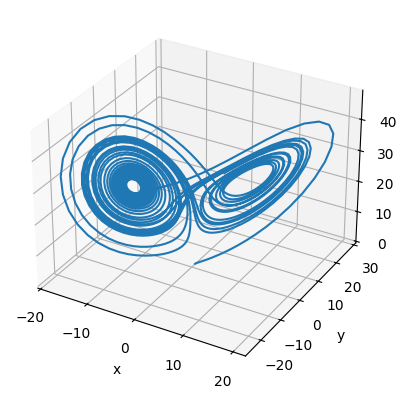

In [10]:
ax = plt.figure().add_subplot(projection="3d")
ax.plot3D(sol_est[0], sol_est[1], sol_est[2])
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
plt.show()

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (2,) + inhomogeneous part.

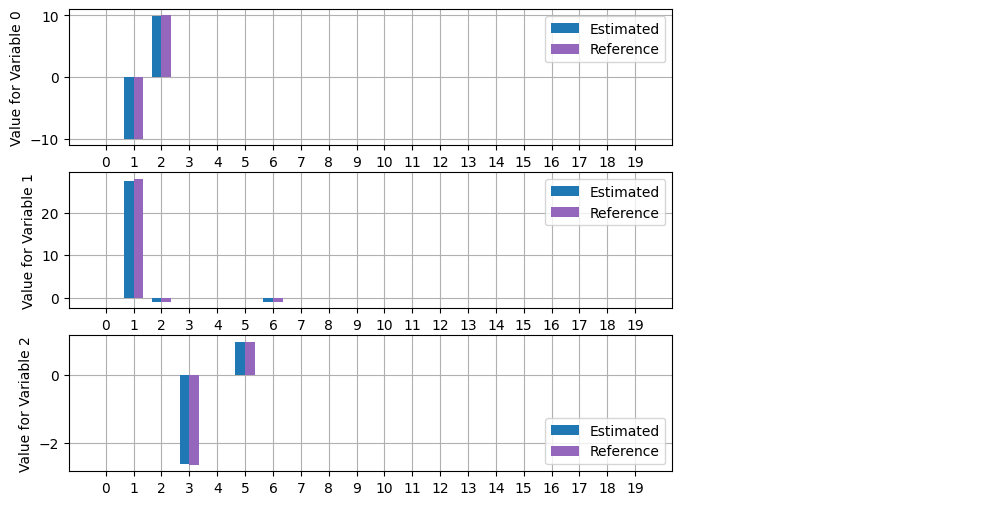

In [11]:
from tsme.utils.visualization import barplot_parameters
sigma = estimated_model.sigma

sigma_true = np.zeros(sigma.shape)
sigma_true[0, 1] = -10
sigma_true[0, 2] = 10
sigma_true[1, 1] = 28
sigma_true[1, 2] = -1
sigma_true[1, 6] = -1
sigma_true[2, 3] = - 8./3.
sigma_true[2, 5] = 1

labels = estimated_model.print_strings[:-1]
barplot_parameters(sigma, sigma_true, labels=labels, figsize=(12, 6))